<h1>Quantum Shadow Sampling</h1>

In [1]:
### General Imports ###
import numpy             as np
import numpy.linalg      as la
import scipy.linalg      as sla
import scipy.integrate    as spi
import pyLIQTR.sim_methods.quantum_ops  as  qops  
import matplotlib.pyplot  as plt
from itertools import combinations
import shadows as sh
import random

<hr>
<h2>Shadow Tomography</h2>

Estimating properties of an unknown quantum state is an important and nontrivial task, both for experimental purposes (e.g. estimating fidelities or verifying entanglement in an engineered quantum system) and quantum algorithms (e.g. estimating gradients in QML algorithms or expectation values in VQE). For reasonable estimations of such properties, traditional methods like quantum state tomography require an exponentially growing number of measurements to estimate an exponentially growing number of necessary observables with system size. Shadow tomography seeks to describe not an entire quantum state, but a "shadow" of it on a set of measurements \cite{Aaronson}. Leveraging this, \cite{Huang2020} proposed a $\textit{classical}$ description of quantum states called $\textit{classical shadows}$, which can accurately predict $M$ different functions (expectation values for particular observables with respect to the state) of the quantum state with only $O(\log{M})$ measurements.

While \cite{Huang2020}'s work drastically reduces the number of required measurements, it still requires saving and manipulating a measurement operator for each such measurement, for which the time/memory still grows exponentially. In 2023, \cite{Heidari} introduced a new approach in an attempt to address, called $\textit{Quantum Shadow Samping (QSS)}$. QSS works by keeping the state representations quantum instead of classical, and performing most of the necessary computations for constructing shadows/estimating expectation values on quantum hardware itself. \cite{Heidari} uses this as a subroutine in a quantum gradient descent algorithm, which only requires unbiased (not necessarily accurate) estimations. As such, the relationship between accuracy and sample complexity for this protocol is not currently well defined.

In this work, we aim to explore the accuracy of QSS via numerical simulation, and compare it to the Classical Shadow protocol. Particularly, in this notebook we extend the `shadows` module of `pyLIQTR` to support QSS in addition to Classical Shadows, and test both for the task of estimating expectation values of a 3-qubit Gibbs state (an important task for quantum optimization algorithms in its own right). More details on how both protocols work (and our approach to implementing both) are included as well.

<h2> Quantum Gibbs States </h2>
Gibbs states are mixed quantum states which describe systems in thermodynamic equilibrium with their environment at finite temperatures. Gibbs states are important towards quantum statistical mechanics and their properties have far-reaching applications from materials design to optimization and machine learning. We can define a Gibbs state for a given system using a density matrix of the form:

\begin{equation}
\rho_\beta = e^{-\beta H_{sys}}/Z
\end{equation}

where $ Z = \text{Tr}e^{-\beta H_{sys}}$ is the partition function, $\beta$ is inverse temperature, and $H$ is the system Hamiltonian. 

Let us begin by considering an example of a 3-qubit XXZ-Heisenberg Hamiltonian. Namely:
\begin{equation}
    H_{sys} = \sum\limits_{i=1}^{N-1} \left(J_x\sigma^x_{i}\otimes\sigma^x_{i+1}+J_y\sigma^y_{i}\otimes\sigma^y_{i+1}+J_z\sigma^z_{i}\otimes\sigma^z_{i+1}\right) + \sum\limits_{i=1}^{N} \left( h_x \sigma^x_i + h_y \sigma^y_i + h_z \sigma^z_i \right)
\end{equation}

for $N=3$. The details behind implementing such a Hamiltonian with `pyLIQTR` can be found in the 'Heisenberg' tutorial, and the parameter values are made clear in the code. Here, we calculate the Gibbs state for this Hamiltonian.

In [2]:
# Define Hamiltonian as in Heisenberg tutorials, using the XXZ model

# Hamiltonian parameters

N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

In [3]:
# Generate input parameter sets
tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)

# Generate Hamiltonian array
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

With the Hamiltonian defined above, we need only specify an inverse temperature, and then we can calculate our Gibbs State.

In [4]:
# # Let us define our inverse temperature as beta = 0.5
beta = 1.5

# Calculate Gibbs State
rho_beta = sla.expm(-beta*H)
Z = np.trace(rho_beta)
rho_beta = rho_beta/Z

Here, we aim test two algorithms for sampling from the Gibbs state by estimating their expectation values for some sets of operators. For this example, our operator set will consist of all one and two qubit Pauli operators $O_i \in O$ such that each $O_i = \bigotimes\limits^{N}_{j=1} o_j$, where at most two $o_j \in \{X, Y, Z\}$ and the rest are $I$.

Let us define the following lists:

1. `O`: a list of operators (`numpy` arrays) which corresponds to the set $O$

2. `M`: a list of dictionaries containing the location of the Pauli operators for each observable $O_i \in O$, as well as an operator (`numpy` array) to measure them $M_{O_i} = \bigotimes\limits^{N}_{j=1} m_j$ where $m_j = H, S^{\dagger}H$ if $o_j = \sigma^x, \sigma^y$ respectively and $I$ otherwise.

3. `O_strings`: a list of strings that correspond to each Pauli operator $O_i$.

4. `O_list`: a list of representations of each $O_i$ as a list of IDs corresponding to the $o_j$'s: $\sigma^{x} \rightarrow 0, \sigma^{y} \rightarrow 1, \sigma^{z} \rightarrow 2, I \rightarrow 3$. These help simplify calculations for the Classical Shadows protocol (see the `shadows` module for details).

In [5]:
# Define our sets of measurement operators and observables as all one and two qubit Pauli operators 
op_tuples = list(combinations(range(N), 2)) # All potential 'locations' for two Paulis on N qubits
paulis = [qops.px, qops.py, qops.pz]

M = []
O = []
O_list = []

# One qubit pauli operators over N qubits
for i in range(N):
    mops = [qops.id]*N
    ops = [qops.id]*N
    op_ids = [3]*N

    for j in range(3):
        mops[i] = sh.p_bases[j]
        ops[i] = paulis[j]

        M.append({'pLoc': i, 'value': qops.multikron(mops)})
        O.append(qops.multikron(ops))

        op_ids[i] = j
        O_list.append(op_ids.copy())

# Two qubit pauli operators over N qubits
for tuple in op_tuples:
    mops = [qops.id]*N
    ops = [qops.id]*N
    op_ids = [3]*N

    for i in range(3):
        for j in range(3):
            mops[tuple[0]] = sh.p_bases[i]
            mops[tuple[1]] = sh.p_bases[j]
            M.append({'pLoc': tuple, 'value': qops.multikron(mops)})

            ops[tuple[0]] = paulis[i]
            ops[tuple[1]] = paulis[j]
            O.append(qops.multikron(ops))

            op_ids[tuple[0]] = i
            op_ids[tuple[1]] = j
            O_list.append(op_ids.copy())

Next, we use `O` to calculate the exact expectation values for the set $O$ w.r.t. $\rho_\beta$. The other lists will become useful later on.

In [6]:
# Expectation values of operators for Gibbs State
Gbs_expct = sh.expect_set(O, rho_beta)

print('TRUE EXPECTATION VALUES:')
for expct in Gbs_expct:
    print(expct)

TRUE EXPECTATION VALUES:
(0.6088924978618702+0j)
-3.3285006695304986e-16j
(2.220446049250313e-16+0j)
(-0.3104951051177654+0j)
5.551115123125783e-17j
0j
(0.60889249786187+0j)
-2.220446049250313e-16j
(3.885780586188048e-16+0j)
(-0.6702405807740384+0j)
-1.6653345369377348e-16j
(5.551115123125783e-17+0j)
1.1102230246251565e-16j
(-0.6683111592086682+0j)
7.654467337747661e-17j
0j
2.7755575615628914e-17j
(-0.6539321506861399+0j)
(0.3455771516806042+0j)
1.3877787807814457e-16j
(-5.551115123125783e-17+0j)
-2.7755575615628914e-17j
(0.3383756497672158+0j)
-8.998878031629687e-17j
(-1.1102230246251565e-16+0j)
-5.551115123125783e-17j
(0.3094308613665861+0j)
(-0.6702405807740386+0j)
-5.551115123125783e-17j
(-1.1102230246251565e-16+0j)
5.551115123125783e-17j
(-0.6683111592086683+0j)
2.7755575615628914e-17j
(1.1102230246251565e-16+0j)
5.551115123125783e-17j
(-0.65393215068614+0j)


<hr>
<h2>Classical Shadows</h2>

Classical shadows can be constructed from randomized measurements of a quantum state, and used to efficiently predict many of its properties. Consider an $n$-qubit state $\rho$, prepared by some circuit (in this case our Gibbs state). The procedure works by applying some unitary transformation $V$, chosen randomly from some ensemble, to $\rho$ before measuring the resulting state ($V\rho V^{\dagger}$) in the computational basis for some outcome $\ket{b}$. 

From the measurement outcome $\ket{b}$, we store the 'reverse' operation of our random measurement in classical memory: $V^{\dagger} \ket{b}\bra{b} V$. We call this value a 'snapshot' of our state. The average of these snapshots defines a quantum measurement channel, $\mathcal{M}$. Thus, we can construct a Classical Shadow of $\rho$ with respect to $V$ and $\ket{b}$ like so:

\begin{equation}
\hat{\eta}_{V,b} = \mathcal{M}^{-1}(V^{\dagger}\ket{b}\bra{b} V)
\end{equation}

The inverse of $\mathcal{M}$ is a linear map, which depends on the ensemble from which $V$ is sampled. Note that this linear map is not CPTP, but since we only use it for classical post-processing, this does not pose a problem. Two common ensembles used for generating random unitaries are

1. Random Clifford measurements: $V \in Cl(2^n)$
2. Random Pauli measurements: $V = V_1 \otimes ... \otimes V_n \in Cl(2)^{\otimes n}$

The first is equivalent to generating a random clifford circuit (for which a polynomial time algorithm exists) while the second is equivalent to measuring each qubit in a randomly chosen pauli-X, Y, or Z basis. For Clifford measurements, $\hat{\eta}_{V,b} = (2^n + 1)V^{\dagger}\ket{b}\bra{b} V - I$ while for Pauli measurements $\hat{\eta}_{V,b} = \bigotimes^{n}_{j=1}(3 V^{\dagger}_j\ket{b_j}\bra{b_j} V_j - I) $.

The QSS protocol has also been designed around random Pauli measurements, so using it for our implementation of Classical Shadows makes sense for comparison. Moreover, random Pauli measurements only require a constant gate depth and a linear number of gates, so this is easier to simulate than the polynomial-depth/gate random Cliffords (though `pyLIQTR` does support use of random clifford circuits in the `shadows` module).

The state $\rho$ can be classically reconstructed as the expectation value of our shadows over random clifford unitaries: $\rho = \mathbb{E}_{V,b}[\hat{\eta}_{V,b}]$. Thus, for any of our operators $O_j \in O$ :

\begin{equation}
\braket{O_i}_{\rho} = \text{Tr}(\rho O_j) = \text{Tr}(\mathbb{E}[\hat{\eta}_{V,b}] O_i) = \mathbb{E}[\text{Tr}(\hat{\eta}_{V,b} O_i)] = \mathbb{E}_{V,b}[\braket{O_j}_{\hat{\eta}_{V,b}}]
\end{equation}

In other words, the expectation value of an operator for a given state can be estimated by an average of the expectation values for many classical shadows. 

<hr>

Now, we consider the question of <i>how many</i> classical shadows we should use for a given expectation value estimation, and <i>how</i> we should average them. The classical shadow protocol typically employs a median of means estimator, that is, a sample of $n_s$ shadows is broken into $K$ equally sized sets of size $S$ and we take the median of the $K$ set means (each calculated from $S$ shadows). The values of $S$ and $K$ are directly related to the performance of our estimation and our observables. Specifically:

\begin{equation}
S = \frac{6\sigma^2}{\epsilon^2}
\end{equation}

where $\epsilon$ is our desired error bound. Also note that for random pauli measurements $\sigma^2 \lesssim 3^{\text{locality}(O)}$.

\begin{equation}
K = (9/2)\log(M/\delta) 
\end{equation}

where  $M$ is the number of observables whose expectation values we are estimating, and the probability that a given estimation falls within our error bound is $1-\delta$.

Thus, we can conclude that for a given $\epsilon, \delta$ we need at least

\begin{equation}
n_s = SK = 27\frac{\sigma^2}{\epsilon^2}\log(M/\delta)
\end{equation}

shadows. Crucially, this suggests that we can estimate $M$ expectation values with $O(\log M)$ measurements!

In [7]:
delta = 0.01
epsilon = np.array([1 - 0.1*x for x in range(9)])
print('error tolerances to test:')
print(epsilon)

K = int(np.rint((9/2)*np.log(len(O)/delta)))
S = np.rint((6/(epsilon**2))*(3**2)).astype(int)

sizes = list(K*S)
print('number of shadows required for each error tolerance, epsilon:')
print(sizes)


error tolerances to test:
[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2]
number of shadows required for each error tolerance, epsilon:
[1998, 2479, 3108, 4070, 5550, 7992, 12506, 22200, 49950]


The following calculates such estimates for various-sized sets of classical shadows of $\rho_\beta$. The equations described above for calculating classical shadows are implemented in the `shadows` module and called here. As the results show, the more shadows we use the better the estimate, and errors can get very small, suggesting that classical shadows are indeed useful estimation tools in this case.

In [8]:
# Classical Shadows for exact  state
gibshadow_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    print('Now estimating using: '+str(n_s)+' shadows')
    for i in range(n_s):
        estimates.append(sh.shadow_estimation(rho_beta, N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    gibshadow_errors.append(error)

Now estimating using: 1998 shadows


Now estimating using: 2479 shadows
Now estimating using: 3108 shadows
Now estimating using: 4070 shadows
Now estimating using: 5550 shadows
Now estimating using: 7992 shadows
Now estimating using: 12506 shadows
Now estimating using: 22200 shadows
Now estimating using: 49950 shadows


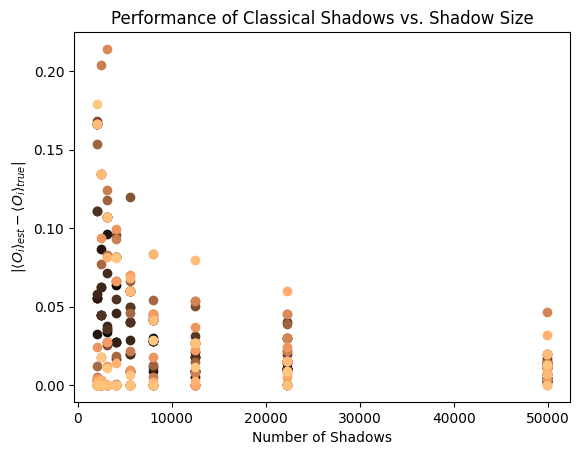

In [9]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_i \rangle _{est} - \langle O_i \rangle _{true}$|')
i = 0
for errors in np.array(gibshadow_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.title('Performance of Classical Shadows vs. Shadow Size')
plt.show()

The above shows the error in expectation value between the classical shadow estimation and  our operators, for different numbers of shadows. We can compare this to the theoertical error bound based on our $\epsilon$ as calculated earlier:

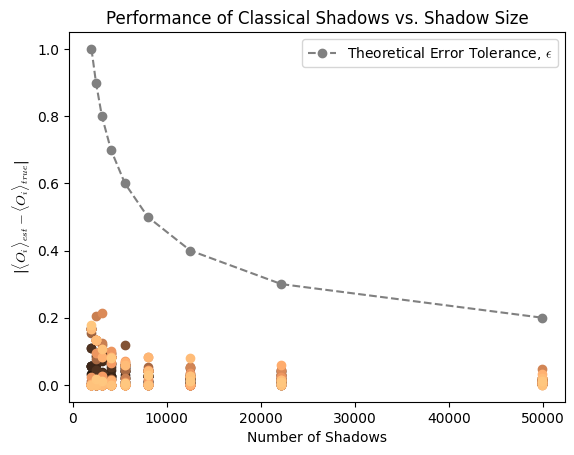

In [10]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_i \rangle _{est} - \langle O_i \rangle _{true}$|')
i = 0
for errors in np.array(gibshadow_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,abs(epsilon), '--o', color='grey', label='Theoretical Error Tolerance, $\epsilon$')
plt.title('Performance of Classical Shadows vs. Shadow Size')
plt.legend()
plt.show()

<hr>
<h2>QSS</h2>

Quantum Shadow Sampling is a fully quantum variant of shadow sampling. While classical shadows rely on computations done on classical devices (the size of which grow exponentially with system size), QSS does estimations through measurements of $\textit{quantum shadows}$ in a quantum circuit. The beginning of the protocol is identical to its classical counterpart. For some $N$-qubit state $\rho$, evolve it by some random unitary $V = \in \{H, HS^{\dagger}, I\}^{\otimes N}$ and take a measurement, whose outcome is a bitstring $b = b_1 b_2 ... b_N$. 
<br>
<br>
But now, $b$ is passed through a channel $Q[b]$ which flips each bit with probability $\frac{1}{3}$, returning the altered bitstring $c$ and a weight $w = \prod\limits_{j=1}^{N}w_j$ where $w_j = -1$ if $c_j \neq b_j$. Next, a quantum state $\ket{c} = \bigotimes\limits^{N}_{j=1}\ket{c_j}$ and is now evolved with $V^{\dagger}$ such that $\ket{\omega} = V^{\dagger}\ket{c}$. The state $\Phi = \ket{\omega}\bra{\omega}$ and weight $w$ are our $\textit{quantum shadows}$. See the illustration below for a comparison of what a single shadow measurement may look like for both QSS and Classical Shadows, in terms of quantum circuits.

<figure>
  <img src="Figures/Classical Shadow.png">
  <img src="Figures/Quantum Shadow.png">
  <figcaption>Circuits for constructing a classical shadow (top) and quantum shadow (bottom)</figcaption>
</figure>

Crucially, the outcome $b$ is classical and can be copied, so from a single random measurement of $\rho$ we can generate many quantum shadows. As a result, the calculation of each expectation value $\text{Tr}(\eta_{V,b}O_i)$ can be estimated using the second quantum circuit. Specifically, to estimate an expectation value using a shadow, we measure $\Phi$ in the basis of $O_i$ and multiply it by $w$. For the Pauli observables we consider in this work, this amounts to appending the measurement operators $M_i$ to the quantum circuit (only requiring an additional constant circuit depth)
<hr>


The QSS procedure is used in \cite{Heidari} to estimate loss gradients. Suppose the inputs from some training data are quantum samples $\ket{\phi}$ drawn from some distribution $D$. Then the goal would be to estimate the expectation value for each $O_i$ with respect to the expected mixed state $\mathbb{E}_D[\ket{\phi}\bra{\phi}]$ of these samples, if the set $O$ contains all the derivatives necessary for loss gradient. For a set of $n$ quantum samples $\{\ket{\phi_k}\}_{k=1}^n$, this can be done by (for each $\ket{\phi_k}$) generating a quantum shadow $\Phi_i$, $w_i$ for each observable $O_i$ and performing the corresponding measurement $M_i$. If the outcome for each state/observable is $b_{ki}$, then the estimate for $\langle O_i \rangle _{\mathbb{E}_D[\ket{\phi}\bra{\phi}]}$  is: 

\begin{equation}
\widehat{\langle O_i \rangle} _{\mathbb{E}_D[\ket{\phi}\bra{\phi}]} = \frac{3^N}{n} \sum\limits_{k=1}^{n} w_i b_{k,i}
\end{equation}

The number of measurements required for this estimation is clearly $O(nM)$ where $n$ is the number of smaples from $D$ and $M$ is the number of observables. Note that in principle, we can replace $3^N$ to $3^{locality(O_i)}$. Moreover, by Theorem 2 of \cite{Heidari}, it is known that this estimation technique is $\textit{unbiased}$, or 'correct' on average. However, to achieve convergence for QSGD, the $\textit{esitmate}$ need not be accurate so long as the $\textit{estimator}$ is unbiased. In other words, the measurement complexity becomes exactly n*M while still achieving convergence.

Now, setting aside QSGD, let us consider how and why one might adapt QSS for our task of estimating Gibbs state expectation values. Firstly, the process of sampling from some distribution with the "expected" state being a mixed state would be analagous to sampling from the Gibbs state, which of course is a mixed state itself. A procedure for generating such samples (with some failure probability) and using them for $\textit{classical}$ shadows is given in \cite{Coopmans}, and implemented in Tutorials 1a and 1b in this `Gibbs` directory. Considering that samping procedure also brings up another motivation for using QSS: resource compatilibity. As the analysis in `Tutorial_2_Gibbs_Resources.ipynb` suggests, while gate/depth complexity for \cite{Coopmans}'s algorithm scales (at best) linearly with system size, the actual numbers for gate count/depth are completely unrealistic for NISQ devices. However, implementing this algorithm with some future, larger-scale devices wouldn't make sense either, given the exponentially growing classical computations involved with classical shadows. If we can combine \cite{Coopmans} and QSS, we could potentially at least address the latter issue.


While this describes the motivation behind investigating QSS, here we will omit this from our simulations for simplicity, calculating shadows/estimations on the exact Gibbs state through matrix/operator algebras (in other words, each "sample" is just the Gibbs state itself). This way, the behavior we observe can be attributed to the QSS protocol as opposed to the sampling protocol, and we can potentially gain some insights as to whether or not it is even worthwhile to try and combine the two.
<hr>

<h2>QSS Implementation and Results</h2>

We aim to numerically evaluate the accuracy of the QSS protocol and how it relates to the required number of measurements. Recall that we are computing (estimating) the expectation value for each observable for every sample using the second quantum circuit. This means that for every sample measured from the first quantum circuit, we perform $O(M)$ measurements on the second. For the sake of simplicity, let us take $\textit{exactly}$ $M$ measurements per sample. But how many samples should we take in the first place? This depends on our estimator.

Let us start with the estimator from \cite{Heidari}, which uses the arithmetic mean. By Cantelli's equation \cite{}, we can conclude that we need about:
\begin{equation}
n = \frac{(1-\delta_i)\sigma^2}{\delta_i \epsilon^2}
\end{equation}
samples, where $\delta_i$ is the failure probability for an $\textit{individual}$ observable, so $\delta_i = \delta/M$. Thus, in terms of the same parameters we used for classical shadows, we have:
\begin{equation}
n = \frac{(M-\delta_)\sigma^2}{\delta \epsilon^2}
\end{equation}

Now, this analysis purely concerns the sample, i.e., it assumes correctness for the $M$ calculations done with the second quantum circuit (due to taking exactly $M$ measurements per sample). Of course, very little accuracy can be expected when we are essentially only measuring each observable once. Let us see how that is reflected when we test it below.

In [11]:
# NB: we don't include all the same values of $\epsilon$ as we have done previously because for the arithmetic mean estimator, the number of smaples required is very large even for larger values of $\epsilon$.
sample_sizes = list(np.rint((len(O) - delta)*(3**2)/(delta*(epsilon[:5]**2))).astype(int))
print('For the epsilon values')
print(epsilon[:5])
print('\nWe require')
print(sample_sizes)
print('samples')

For the epsilon values
[1.  0.9 0.8 0.7 0.6]

We require
[32391, 39989, 50611, 66104, 89975]
samples


In [12]:
errors = []
for n in sample_sizes:
    shadow_expct_estimates = []
    print('Now performing QSS on '+str(n)+' samples')
    for i in range(n):
        V = sh.random_pBasis(N)[0]
        b = sh.comp_measurement(V @ rho_beta @ V.conj().T)
        shadow_expct_estimates.append(sh.QSS_estimation(b, V, M))
    errors.append(abs(np.mean(shadow_expct_estimates, axis=0) - Gbs_expct))


Now performing QSS on 32391 samples
Now performing QSS on 39989 samples
Now performing QSS on 50611 samples
Now performing QSS on 66104 samples
Now performing QSS on 89975 samples


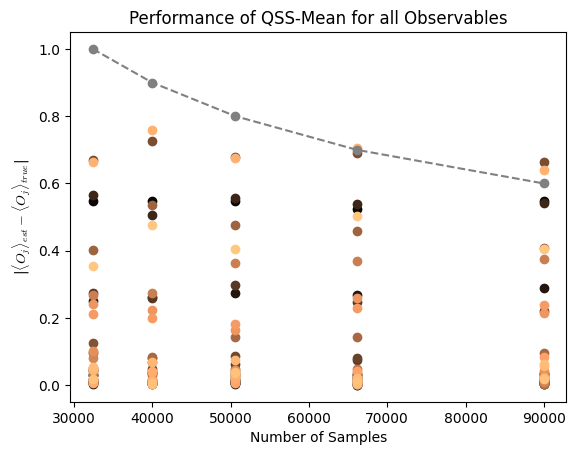

In [13]:
plt.xlabel('Number of Samples')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for e in np.array(errors).T:
    i += 1
    plt.scatter(sample_sizes, e, color=plt.cm.copper(i/len(O)))
plt.plot(sample_sizes,abs(epsilon[:5]), '--o', color='grey', label='$\epsilon$')
plt.title('Performance of QSS-Mean for all Observables')
plt.show()

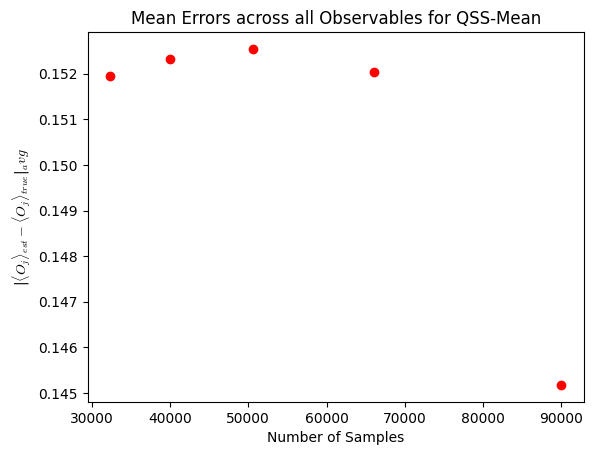

In [14]:
plt.xlabel('Number of Samples')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|$_avg$')
for j in range(len(sample_sizes)):
    plt.scatter(sample_sizes[j], np.mean(errors[j]), color='red')
plt.title('Mean Errors across all Observables for QSS-Mean')
plt.show()

Now, let us try using the median of means estimator. We simply take the median of means with the data points being each $w_ib_{ik}$. The analysis for sample complexity is then exactly the same as the shadow complexity for classical shadows. As a reminder, here are the values (which now include all values of epsilon as before!)

In [15]:
print('For the epsilon values')
print(epsilon)
print('\nWe require')
print(sizes)
print('samples')

For the epsilon values
[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2]

We require
[1998, 2479, 3108, 4070, 5550, 7992, 12506, 22200, 49950]
samples


In [16]:
errors_mom = []
for n in sizes:
    shadow_expct_estimates = []
    print('Now performing QSS on '+str(n)+' samples')
    for i in range(n):
        V = sh.random_pBasis(N)[0]
        b = sh.comp_measurement(V @ rho_beta @ V.conj().T)
        shadow_expct_estimates.append(sh.QSS_estimation(b, V, M))
    errors_mom.append(abs(sh.med_of_mean(np.array(shadow_expct_estimates), K) - Gbs_expct))


Now performing QSS on 1998 samples
Now performing QSS on 2479 samples
Now performing QSS on 3108 samples
Now performing QSS on 4070 samples
Now performing QSS on 5550 samples
Now performing QSS on 7992 samples
Now performing QSS on 12506 samples
Now performing QSS on 22200 samples
Now performing QSS on 49950 samples


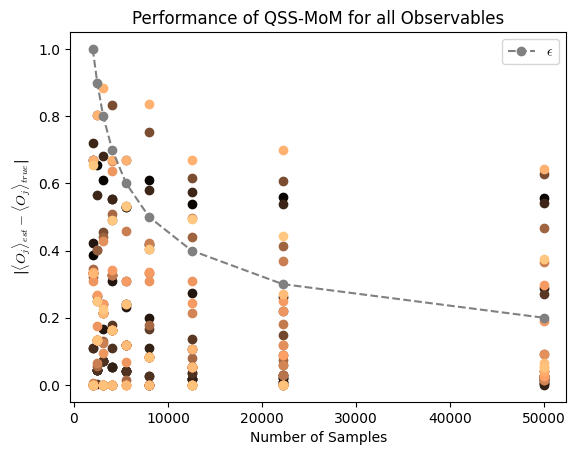

In [17]:
plt.xlabel('Number of Samples')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for e in np.array(errors_mom).T:
    i += 1
    plt.scatter(sizes, e, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,abs(epsilon), '--o', color='grey', label='$\epsilon$')
plt.legend()
plt.title('Performance of QSS-MoM for all Observables')
plt.show()

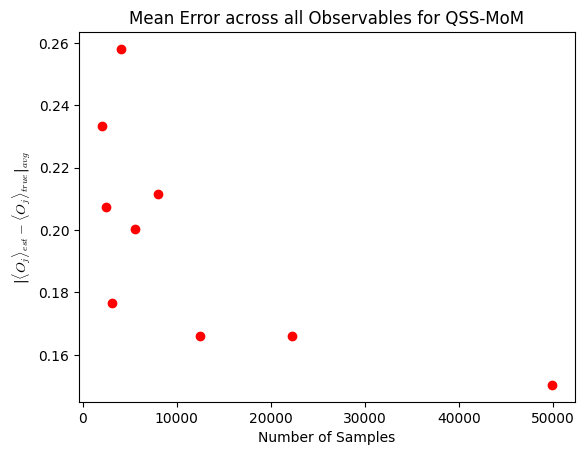

In [18]:
plt.xlabel('Number of Samples')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|$_{avg}$')
for j in range(len(sizes)):
    plt.scatter(sizes[j], np.mean(errors_mom[j]), color='red')
plt.title('Mean Error across all Observables for QSS-MoM')
plt.show()

Now, let us take a look at the accuracy of the QSS estimations for each sample. As mentioned prior, the calculation of sample expectation value estimates can only be accurate based on its own measurement complexity, since it is done on a quantum circuit.